# Amazon Review Sentiment Analysis-Hybrid MODEL(LSTM+GRU)

In [5]:
# Importing Libraries
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Scikit-learn for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score, accuracy_score,
                             precision_score, recall_score, f1_score)

# NLTK for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, LSTM, SpatialDropout1D, Embedding,
                                     Bidirectional, Dropout, GlobalMaxPooling1D,
                                     Input, GRU)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop


# Load the Dataset into a DataFrame

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

def get_labels_and_texts(file, num_samples=None):
    labels = []
    texts = []
    with open(file, "r", encoding='utf-8') as f:  # Open in text mode with utf-8 encoding
        for i, line in enumerate(f):
            if num_samples is not None and i >= num_samples:
                break
            x = line.split(" ", 1)  # Split line into label and text
            labels.append(int(x[0].split("__label__")[1]) - 1)
            texts.append(x[1].strip())
    return np.array(labels), texts

train_labels, train_texts = get_labels_and_texts("Dataset/train.ft.txt", num_samples=3600000)
test_labels, test_texts = get_labels_and_texts("Dataset/test.ft.txt", num_samples=400000)

train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})


# Clean and Preprocess the Data

In [11]:
#Cleaning
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

In [12]:
# Tokenize texts
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

In [13]:
# Padding
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH, padding='post')
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH, padding='post')

# Define the model architecture 

In [15]:
#GRU_LSTM Model definition
max_seq_length = MAX_LENGTH
vocab_size = 12000
embedding_dim = 128
lstm_units = 128
dropout_rate = 0.1

inputs = Input(shape=(max_seq_length,), name='input_layer')
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length, name='embedding_layer')(inputs)
spatial_dropout = SpatialDropout1D(dropout_rate, name='spatial_dropout')(embedding)
lstm = Bidirectional(LSTM(lstm_units, return_sequences=True), name='bidirectional_lstm')(spatial_dropout)
gru = Bidirectional(GRU(lstm_units, return_sequences=True), name='bidirectional_gru')(lstm)
pooling = GlobalMaxPooling1D(name='global_max_pooling')(gru)
dense = Dense(64, activation='relu', name='dense')(pooling)
dropout = Dropout(dropout_rate, name='dropout')(dense)
outputs = Dense(1, activation='sigmoid', name='output_layer')(dropout)
model = Model(inputs=inputs, outputs=outputs, name='custom_model')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
print(model.summary())

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 255)]             0         
                                                                 
 embedding_layer (Embedding)  (None, 255, 128)         1536000   
                                                                 
 spatial_dropout (SpatialDro  (None, 255, 128)         0         
 pout1D)                                                         
                                                                 
 bidirectional_lstm (Bidirec  (None, 255, 256)         263168    
 tional)                                                         
                                                                 
 bidirectional_gru (Bidirect  (None, 255, 256)         296448    
 ional)                                                          
                                                      

# Train the Model

In [ ]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

In [ ]:
optimizer = RMSprop(learning_rate=0.000025)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Hybrid_fbest_model', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, epochs=60, batch_size=128, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint], verbose=1)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Hybrid_loss_curve.png')
plt.show()

Epoch 1/60
22500/22500 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.8933 - precision_1: 0.8973 - recall_1: 0.8883

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 3844s 171ms/step - loss: 0.2593 - accuracy: 0.8933 - precision_1: 0.8973 - recall_1: 0.8883 - val_loss: 0.2113 - val_accuracy: 0.9156 - val_precision_1: 0.9382 - val_recall_1: 0.8899
Epoch 2/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9248 - precision_1: 0.9270 - recall_1: 0.9222

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 3836s 170ms/step - loss: 0.1938 - accuracy: 0.9248 - precision_1: 0.9270 - recall_1: 0.9222 - val_loss: 0.1721 - val_accuracy: 0.9338 - val_precision_1: 0.9365 - val_recall_1: 0.9308
Epoch 3/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9358 - precision_1: 0.9371 - recall_1: 0.9343

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 3946s 175ms/step - loss: 0.1684 - accuracy: 0.9358 - precision_1: 0.9371 - recall_1: 0.9343 - val_loss: 0.1589 - val_accuracy: 0.9397 - val_precision_1: 0.9371 - val_recall_1: 0.9429
Epoch 4/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9407 - precision_1: 0.9418 - recall_1: 0.9394

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 3981s 177ms/step - loss: 0.1574 - accuracy: 0.9407 - precision_1: 0.9418 - recall_1: 0.9394 - val_loss: 0.1538 - val_accuracy: 0.9419 - val_precision_1: 0.9548 - val_recall_1: 0.9278
Epoch 5/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9434 - precision_1: 0.9445 - recall_1: 0.9422

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 4001s 178ms/step - loss: 0.1510 - accuracy: 0.9434 - precision_1: 0.9445 - recall_1: 0.9422 - val_loss: 0.1469 - val_accuracy: 0.9449 - val_precision_1: 0.9431 - val_recall_1: 0.9469
Epoch 6/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.9454 - precision_1: 0.9464 - recall_1: 0.9442

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 3981s 177ms/step - loss: 0.1467 - accuracy: 0.9454 - precision_1: 0.9464 - recall_1: 0.9442 - val_loss: 0.1431 - val_accuracy: 0.9463 - val_precision_1: 0.9458 - val_recall_1: 0.9469
Epoch 7/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.9467 - precision_1: 0.9477 - recall_1: 0.9457

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 3993s 177ms/step - loss: 0.1434 - accuracy: 0.9467 - precision_1: 0.9477 - recall_1: 0.9457 - val_loss: 0.1410 - val_accuracy: 0.9472 - val_precision_1: 0.9461 - val_recall_1: 0.9485
Epoch 8/60
22500/22500 [==============================] - 3932s 175ms/step - loss: 0.1406 - accuracy: 0.9479 - precision_1: 0.9488 - recall_1: 0.9468 - val_loss: 0.1416 - val_accuracy: 0.9468 - val_precision_1: 0.9592 - val_recall_1: 0.9334
Epoch 9/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.9489 - precision_1: 0.9499 - recall_1: 0.9479

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 3978s 177ms/step - loss: 0.1383 - accuracy: 0.9489 - precision_1: 0.9499 - recall_1: 0.9479 - val_loss: 0.1371 - val_accuracy: 0.9488 - val_precision_1: 0.9482 - val_recall_1: 0.9496
Epoch 10/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9498 - precision_1: 0.9507 - recall_1: 0.9489

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 3999s 178ms/step - loss: 0.1362 - accuracy: 0.9498 - precision_1: 0.9507 - recall_1: 0.9489 - val_loss: 0.1358 - val_accuracy: 0.9497 - val_precision_1: 0.9486 - val_recall_1: 0.9510
Epoch 11/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9506 - precision_1: 0.9514 - recall_1: 0.9496

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 3974s 177ms/step - loss: 0.1342 - accuracy: 0.9506 - precision_1: 0.9514 - recall_1: 0.9496 - val_loss: 0.1340 - val_accuracy: 0.9502 - val_precision_1: 0.9517 - val_recall_1: 0.9487
Epoch 12/60
22500/22500 [==============================] - 3016s 134ms/step - loss: 0.1325 - accuracy: 0.9515 - precision_1: 0.9523 - recall_1: 0.9506 - val_loss: 0.1357 - val_accuracy: 0.9496 - val_precision_1: 0.9401 - val_recall_1: 0.9605
Epoch 13/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9521 - precision_1: 0.9528 - recall_1: 0.9513

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2475s 110ms/step - loss: 0.1309 - accuracy: 0.9521 - precision_1: 0.9528 - recall_1: 0.9513 - val_loss: 0.1328 - val_accuracy: 0.9508 - val_precision_1: 0.9448 - val_recall_1: 0.9575
Epoch 14/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9528 - precision_1: 0.9535 - recall_1: 0.9520

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2441s 108ms/step - loss: 0.1294 - accuracy: 0.9528 - precision_1: 0.9535 - recall_1: 0.9520 - val_loss: 0.1309 - val_accuracy: 0.9516 - val_precision_1: 0.9562 - val_recall_1: 0.9467
Epoch 15/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9533 - precision_1: 0.9540 - recall_1: 0.9525

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2449s 109ms/step - loss: 0.1281 - accuracy: 0.9533 - precision_1: 0.9540 - recall_1: 0.9525 - val_loss: 0.1303 - val_accuracy: 0.9522 - val_precision_1: 0.9500 - val_recall_1: 0.9548
Epoch 16/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9538 - precision_1: 0.9544 - recall_1: 0.9530

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2460s 109ms/step - loss: 0.1270 - accuracy: 0.9538 - precision_1: 0.9544 - recall_1: 0.9530 - val_loss: 0.1291 - val_accuracy: 0.9525 - val_precision_1: 0.9555 - val_recall_1: 0.9493
Epoch 17/60
22500/22500 [==============================] - 2442s 109ms/step - loss: 0.1258 - accuracy: 0.9543 - precision_1: 0.9549 - recall_1: 0.9537 - val_loss: 0.1299 - val_accuracy: 0.9524 - val_precision_1: 0.9589 - val_recall_1: 0.9453
Epoch 18/60
22500/22500 [==============================] - 2428s 108ms/step - loss: 0.1246 - accuracy: 0.9547 - precision_1: 0.9554 - recall_1: 0.9541 - val_loss: 0.1305 - val_accuracy: 0.9519 - val_precision_1: 0.9425 - val_recall_1: 0.9626
Epoch 19/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9552 - precision_1: 0.9559 - recall_1: 0.9543

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2471s 110ms/step - loss: 0.1236 - accuracy: 0.9552 - precision_1: 0.9559 - recall_1: 0.9543 - val_loss: 0.1275 - val_accuracy: 0.9531 - val_precision_1: 0.9513 - val_recall_1: 0.9552
Epoch 20/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9555 - precision_1: 0.9563 - recall_1: 0.9547

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2470s 110ms/step - loss: 0.1227 - accuracy: 0.9555 - precision_1: 0.9563 - recall_1: 0.9547 - val_loss: 0.1270 - val_accuracy: 0.9537 - val_precision_1: 0.9521 - val_recall_1: 0.9555
Epoch 21/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.9558 - precision_1: 0.9565 - recall_1: 0.9551

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2485s 110ms/step - loss: 0.1219 - accuracy: 0.9558 - precision_1: 0.9565 - recall_1: 0.9551 - val_loss: 0.1260 - val_accuracy: 0.9538 - val_precision_1: 0.9570 - val_recall_1: 0.9504
Epoch 22/60
22500/22500 [==============================] - 2451s 109ms/step - loss: 0.1209 - accuracy: 0.9563 - precision_1: 0.9568 - recall_1: 0.9557 - val_loss: 0.1260 - val_accuracy: 0.9541 - val_precision_1: 0.9551 - val_recall_1: 0.9530
Epoch 23/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9566 - precision_1: 0.9572 - recall_1: 0.9559

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2488s 111ms/step - loss: 0.1200 - accuracy: 0.9566 - precision_1: 0.9572 - recall_1: 0.9559 - val_loss: 0.1248 - val_accuracy: 0.9544 - val_precision_1: 0.9560 - val_recall_1: 0.9527
Epoch 24/60
22500/22500 [==============================] - 2470s 110ms/step - loss: 0.1193 - accuracy: 0.9570 - precision_1: 0.9577 - recall_1: 0.9564 - val_loss: 0.1252 - val_accuracy: 0.9544 - val_precision_1: 0.9545 - val_recall_1: 0.9544
Epoch 25/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9574 - precision_1: 0.9579 - recall_1: 0.9567

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2493s 111ms/step - loss: 0.1186 - accuracy: 0.9574 - precision_1: 0.9579 - recall_1: 0.9567 - val_loss: 0.1243 - val_accuracy: 0.9545 - val_precision_1: 0.9581 - val_recall_1: 0.9505
Epoch 26/60
22500/22500 [==============================] - 2451s 109ms/step - loss: 0.1178 - accuracy: 0.9577 - precision_1: 0.9582 - recall_1: 0.9571 - val_loss: 0.1256 - val_accuracy: 0.9544 - val_precision_1: 0.9608 - val_recall_1: 0.9474
Epoch 27/60
22500/22500 [==============================] - 2482s 110ms/step - loss: 0.1172 - accuracy: 0.9579 - precision_1: 0.9585 - recall_1: 0.9574 - val_loss: 0.1244 - val_accuracy: 0.9545 - val_precision_1: 0.9535 - val_recall_1: 0.9557
Epoch 28/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9582 - precision_1: 0.9587 - recall_1: 0.9576

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2508s 111ms/step - loss: 0.1165 - accuracy: 0.9582 - precision_1: 0.9587 - recall_1: 0.9576 - val_loss: 0.1234 - val_accuracy: 0.9548 - val_precision_1: 0.9591 - val_recall_1: 0.9503
Epoch 29/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9584 - precision_1: 0.9590 - recall_1: 0.9578

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2494s 111ms/step - loss: 0.1160 - accuracy: 0.9584 - precision_1: 0.9590 - recall_1: 0.9578 - val_loss: 0.1232 - val_accuracy: 0.9550 - val_precision_1: 0.9565 - val_recall_1: 0.9533
Epoch 30/60
22500/22500 [==============================] - 2460s 109ms/step - loss: 0.1153 - accuracy: 0.9587 - precision_1: 0.9592 - recall_1: 0.9582 - val_loss: 0.1235 - val_accuracy: 0.9548 - val_precision_1: 0.9509 - val_recall_1: 0.9592
Epoch 31/60
22500/22500 [==============================] - 2457s 109ms/step - loss: 0.1147 - accuracy: 0.9589 - precision_1: 0.9596 - recall_1: 0.9582 - val_loss: 0.1235 - val_accuracy: 0.9548 - val_precision_1: 0.9496 - val_recall_1: 0.9605
Epoch 32/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1141 - accuracy: 0.9593 - precision_1: 0.9598 - recall_1: 0.9587

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2503s 111ms/step - loss: 0.1141 - accuracy: 0.9593 - precision_1: 0.9598 - recall_1: 0.9587 - val_loss: 0.1226 - val_accuracy: 0.9554 - val_precision_1: 0.9532 - val_recall_1: 0.9578
Epoch 33/60
22500/22500 [==============================] - 2442s 109ms/step - loss: 0.1135 - accuracy: 0.9595 - precision_1: 0.9601 - recall_1: 0.9588 - val_loss: 0.1229 - val_accuracy: 0.9554 - val_precision_1: 0.9532 - val_recall_1: 0.9579
Epoch 34/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9598 - precision_1: 0.9602 - recall_1: 0.9593

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2464s 110ms/step - loss: 0.1129 - accuracy: 0.9598 - precision_1: 0.9602 - recall_1: 0.9593 - val_loss: 0.1222 - val_accuracy: 0.9556 - val_precision_1: 0.9553 - val_recall_1: 0.9559
Epoch 35/60
22500/22500 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9599 - precision_1: 0.9604 - recall_1: 0.9594

INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


INFO:tensorflow:Assets written to: Model4-3mdata_fbest_model\assets


22500/22500 [==============================] - 2443s 109ms/step - loss: 0.1124 - accuracy: 0.9599 - precision_1: 0.9604 - recall_1: 0.9594 - val_loss: 0.1220 - val_accuracy: 0.9558 - val_precision_1: 0.9575 - val_recall_1: 0.9540
Epoch 36/60
22500/22500 [==============================] - 2391s 106ms/step - loss: 0.1118 - accuracy: 0.9601 - precision_1: 0.9605 - recall_1: 0.9597 - val_loss: 0.1238 - val_accuracy: 0.9550 - val_precision_1: 0.9479 - val_recall_1: 0.9631
Epoch 37/60
22500/22500 [==============================] - 2415s 107ms/step - loss: 0.1114 - accuracy: 0.9604 - precision_1: 0.9607 - recall_1: 0.9600 - val_loss: 0.1253 - val_accuracy: 0.9550 - val_precision_1: 0.9644 - val_recall_1: 0.9450
Epoch 38/60
13718/22500 [=================>............] - ETA: 14:22 - loss: 0.1105 - accuracy: 0.9607 - precision_1: 0.9611 - recall_1: 0.9602

# Model Evaluation with Metrics

22500/22500 [==============================] - 909s 40ms/step
Validation Accuracy: 0.9561
Precision: 0.9560
Recall: 0.9563
F1 Score: 0.9562
Sensitivity: 0.9563


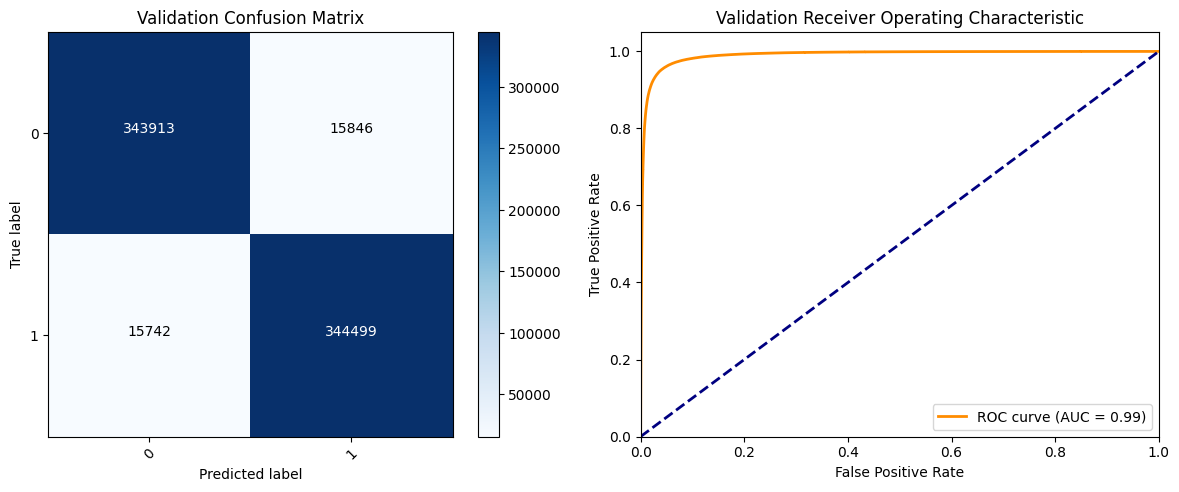

In [17]:
#Evaluation
val_predictions = model.predict(X_val)
val_predictions_prob_positive = val_predictions[:, 0]  
val_predictions_binary = np.where(val_predictions_prob_positive > 0.5, 1, 0)

conf_matrix_val = confusion_matrix(y_val, val_predictions_binary)
fpr_val, tpr_val, _ = roc_curve(y_val, val_predictions_prob_positive)
roc_auc_val = auc(fpr_val, tpr_val)

precision_val, recall_val, _ = precision_recall_curve(y_val, val_predictions_prob_positive)
pr_auc_val = average_precision_score(y_val, val_predictions_prob_positive)

accuracy_val = accuracy_score(y_val, val_predictions_binary)
precision_val = precision_score(y_val, val_predictions_binary)
recall_val = recall_score(y_val, val_predictions_binary)
f1_val = f1_score(y_val, val_predictions_binary)

sensitivity_val = recall_val

print(f'Validation Accuracy: {accuracy_val:.4f}')
print(f'Precision: {precision_val:.4f}')
print(f'Recall: {recall_val:.4f}')
print(f'F1 Score: {f1_val:.4f}')
print(f'Sensitivity: {sensitivity_val:.4f}')

lt.figure(figsize=(12, 5))

classes = ['0', '1']  
plt.subplot(1, 2, 1)
plt.imshow(conf_matrix_val, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(classes)), classes, rotation=45)  # Adjust rotation as needed
plt.yticks(np.arange(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(conf_matrix_val[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_val[i, j] > conf_matrix_val.max() / 2 else "black")

plt.subplot(1, 2, 2)
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('Hbrid_validation_metrics.png')
plt.show()


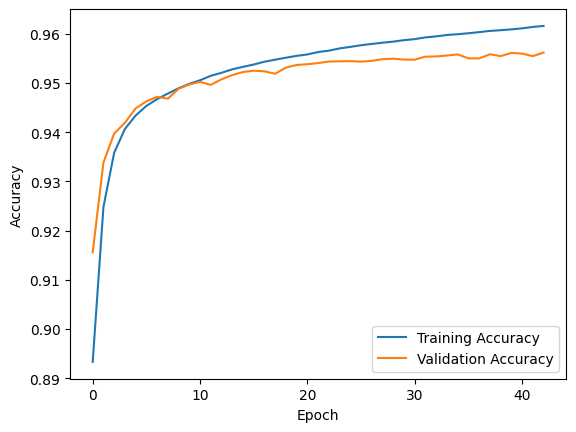

In [18]:
# Plot accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Model4-3mdata_accuracy_curve.png')
plt.show()

12500/12500 [==============================] - 554s 44ms/step
Test Accuracy: 0.9559
Precision: 0.9558
Recall: 0.9561
F1 Score: 0.9559
Sensitivity: 0.9561
ROC AUC: 0.9899
Precision-Recall AUC: 0.9888


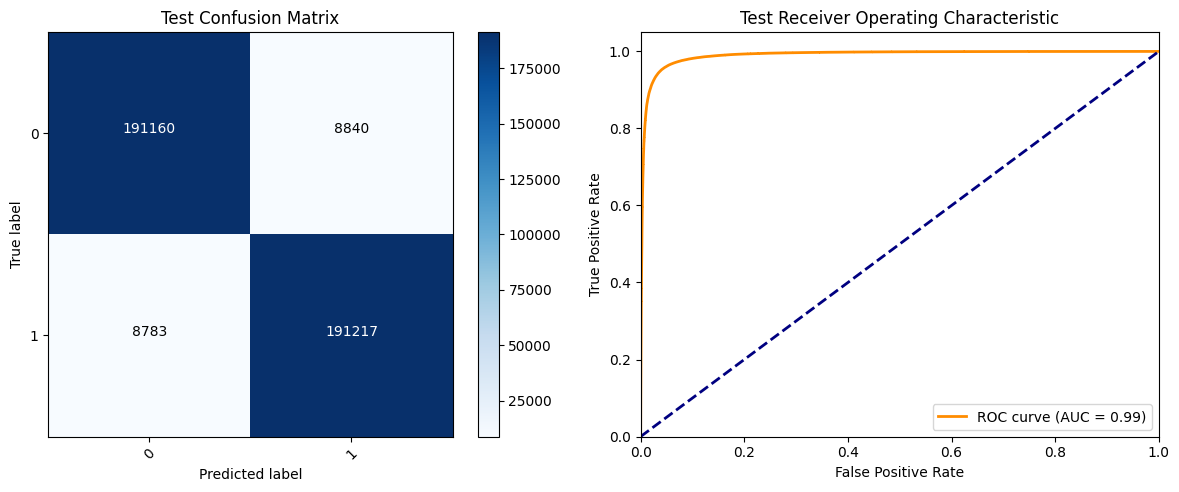

In [21]:
#Confusion Matrix and ROC
test_predictions = model.predict(test_texts)
test_predictions_prob_positive = test_predictions[:, 0]  # Assuming the positive class is index 0
test_predictions_binary = np.where(test_predictions_prob_positive > 0.5, 1, 0)
conf_matrix_test = confusion_matrix(test_labels, test_predictions_binary)
fpr_test, tpr_test, _ = roc_curve(test_labels, test_predictions_prob_positive)
roc_auc_test = auc(fpr_test, tpr_test)

precision_test, recall_test, _ = precision_recall_curve(test_labels, test_predictions_prob_positive)
pr_auc_test = average_precision_score(test_labels, test_predictions_prob_positive)

accuracy_test = accuracy_score(test_labels, test_predictions_binary)
precision_test = precision_score(test_labels, test_predictions_binary)
recall_test = recall_score(test_labels, test_predictions_binary)
f1_test = f1_score(test_labels, test_predictions_binary)
sensitivity_test = recall_test

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1 Score: {f1_test:.4f}')
print(f'Sensitivity: {sensitivity_test:.4f}')
print(f'ROC AUC: {roc_auc_test:.4f}')
print(f'Precision-Recall AUC: {pr_auc_test:.4f}')

plt.figure(figsize=(12, 5))
classes = ['0', '1']  # Replace with your actual class labels
plt.subplot(1, 2, 1)
plt.imshow(conf_matrix_test, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(classes)), classes, rotation=45)  # Adjust rotation as needed
plt.yticks(np.arange(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(conf_matrix_test[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_test[i, j] > conf_matrix_test.max() / 2 else "black")

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('Hybrid_metrics.png')
plt.show()